In [1]:
import os 
import torch
import torch.nn as nn
import torch.nn.functional as F 
import numpy as np
import gym
import warnings
from torch.distributions.categorical import Categorical
warnings.simplefilter("ignore")
from robot_model import *
torch.manual_seed(42)
np.random.seed(42)

from stable_baselines3 import PPO, DDPG
from robot_model import CDPR4_env, CDPR4

device = torch.device("cpu")

In [2]:
modelSB3_PPO = PPO.load("models/ppo_cdpr4_model_3m_timesteps.zip", env=CDPR4_env(), custom_objects={'observation_space': CDPR4_env().observation_space, 'action_space': CDPR4_env().action_space}, print_system_info=True)

== CURRENT SYSTEM INFO ==
- OS: macOS-15.1.1-arm64-arm-64bit Darwin Kernel Version 24.1.0: Thu Oct 10 21:03:15 PDT 2024; root:xnu-11215.41.3~2/RELEASE_ARM64_T6000
- Python: 3.9.20
- Stable-Baselines3: 2.3.2
- PyTorch: 2.4.1.post3
- GPU Enabled: False
- Numpy: 1.23.1
- Cloudpickle: 3.1.0
- Gymnasium: 0.29.1
- OpenAI Gym: 0.26.1

== SAVED MODEL SYSTEM INFO ==
- OS: Linux-5.15.0-125-generic-x86_64-with-glibc2.35 # 135-Ubuntu SMP Fri Sep 27 13:53:58 UTC 2024
- Python: 3.10.12
- Stable-Baselines3: 2.4.0
- PyTorch: 2.4.0+cu124
- GPU Enabled: True
- Numpy: 1.26.1
- Cloudpickle: 3.0.0
- Gymnasium: 1.0.0

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [3]:
robot_model = CDPR4(pos=np.array([.0, .0, 1.]))
dt = 0.1
robot_model.dt = dt
max_force = 15
action_decoder = {
            i: np.array([int(b) for b in f'{i:04b}']) for i in range(16)
        }

def system(model, X, t_span):
    global dt, robot_model
    
    states = np.zeros((t_span.shape[0], X.shape[0]))
    for i in range(t_span.shape[0]):        
        action, _states = model.predict(X, deterministic=True)
        
        u = action #* max_force
        vel = X[3:6]
        dXdt = np.hstack((vel, np.zeros((3,)))).flatten() + robot_model.B() @ u + np.array([0, 0, 0, 0, 0, -g])
        X[:6] = X[:6] + dt*dXdt.flatten()

        states[i, :] = X
        robot_model.pos = np.copy(X[:3])
        
    return states

In [21]:
import matplotlib.pyplot as plt

def plot_states(sol, t_span):
    plt.figure(figsize=(10, 6))
    plt.plot(t_span, sol[:,0], label='x')
    plt.plot(t_span, sol[:,1], label='y')
    plt.plot(t_span, sol[:,2], label='z')
    # plt.plot(t_span, sol[:,3], label='dx')
    # plt.plot(t_span, sol[:,4], label='dy')
    # plt.plot(t_span, sol[:,5], label='dz')
    plt.xlabel('Time')
    plt.ylabel('State Variables')
    plt.title('System')
    plt.legend()
    plt.grid(True)
    plt.show()
    
def plot_position_error(actual_x, desired_x, t_span):
    err = np.array([desired_x - actual_x[i, :3] for i in range(actual_x.shape[0])])
    plt.figure(figsize=(10, 6))
    plt.plot(t_span, err[:,0], label='x err')
    plt.plot(t_span, err[:,1], label='y err')
    plt.plot(t_span, err[:,2], label='z err')
    plt.plot(t_span, [np.linalg.norm(i) for i in err], label='abs err')
    plt.xlabel('Time')
    plt.ylabel('State Variables')
    plt.title('Position Errors')
    plt.legend()
    plt.grid(True)
    plt.show()
    
def get_rms_err(actual_x, desired_x, t_span):
    abs_err = np.array([np.linalg.norm(desired_x - actual_x[i, :3]) for i in range(actual_x.shape[0])]) 
    mean_err = np.mean(abs_err**2)
    return np.sqrt(mean_err)
    

In [16]:
eps = 500
t_span = np.linspace(0, dt*eps, eps)
X=np.array([0,0,1,0,0,0], dtype=np.float32)
des_pos = np.array([1,1,0], dtype=np.float32)
X = np.hstack([X, des_pos])

sol1 = system(modelSB3_PPO, X, t_span)

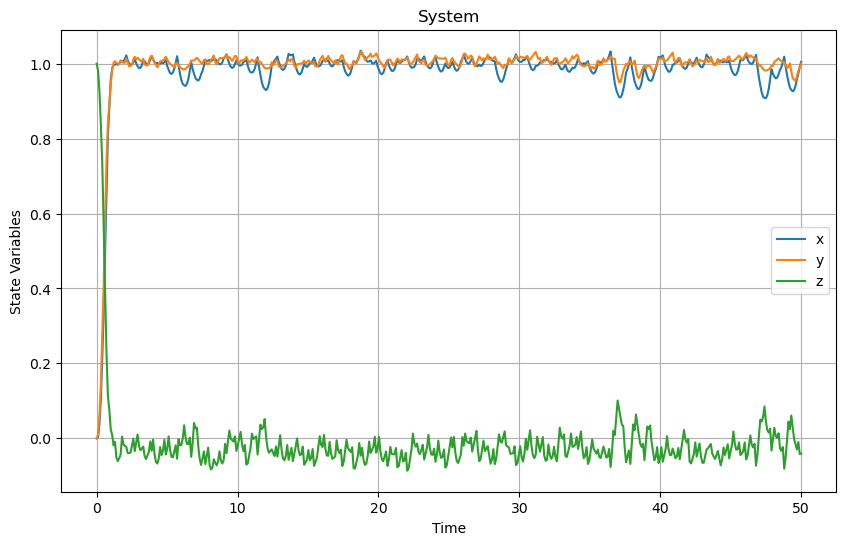

In [17]:
plot_states(sol1, t_span)

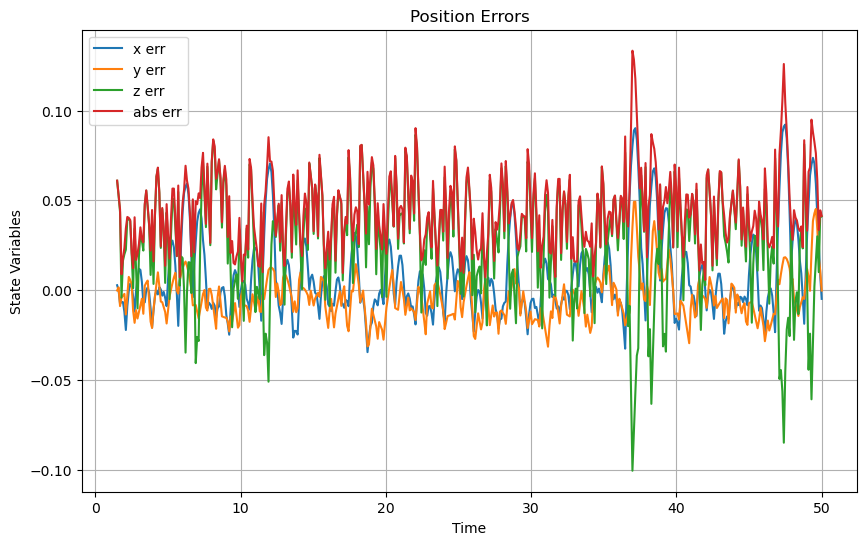

In [19]:
plot_position_error(sol1[15:], des_pos, t_span[15:])

In [22]:
get_rms_err(sol1[15:], des_pos, t_span[15:])

0.049114522835625805